Pygmo was designed to solve tough optimization problems, but that does not mean we can not build an epidemic simulator out of it...

# PYGMO EPIDEMICS

In [1]:
import pygmo as pg
import numpy as np

In [2]:
pg.__version__

'2.14.0'

### Epidemic fundamentals

We will use pygmo islands to simulate a simple, continuous **SIS**-spreading process in a network. The **SIS**-spreading gets its name from the two compartments that each node of the network can belong to:

* **S**: Susceptible (to infection)
* **I**: Infected

Each node in the network will be encapsulated in an island, the contact network is represented by the topology of the archipelago.

### How does a node get infected?

There is an infection process in the **SIS**-model that determines when a node can transit from **S** to **I**. Each infected neighbor of a node contributes with a spreading rate of $\beta$, which is the parameter of a *Poisson*-process. Consequently, the chances of a node to become infected depend directly on the number of infected neighbors. Or, in other words, the time until a node gets infected goes *shorter* the *more* infected neighbors it has. Because the **SIS**-model assumes a *Poisson* spreading process, the interarrival times of infection events can be modelled by an exponential distribution with parameter $\frac{1}{\beta}$.

### How does a node get cured?

A node can switch from **I** to **S**, if gets *cured* (by whatever means). This is modeled by a second *Poisson*-process, which runs on each node with a rate of $\delta$. Similar to the infection process, the curing process on each node will generate curing events based on an exponential distribution with parameter $\frac{1}{\delta}$. In the **SIS**-model, no immunization occurs, so a once cured node can become infected again.

### How is a SIS-model simulated?

The most convenient way to simulate **SIS** is by a *discrete-event simulation* [https://en.wikipedia.org/wiki/Discrete-event_simulation]. Roughly speaking, a central process keeps track of the state of all nodes in the network and generates infection and curing events based on the rules above. Those events are put in a buffer and are processed ordered in time, modyfing the network state and generating new events accordingly.

While this centralized simulator has clear advantages, we propose a distributed simulator based on Pygmos migration capabilities here. Instead of a central buffer that processes all events, each island has its own dedicated buffer with events that only concern itself. Events for infection are modelled as migrants that are fetched and inserted into the island population in between each iteration of the `evolve`-method.

The population on the island has a two-fold purpose: its first individual holds the state of the node (e.g. infected or not) while all other individuals represent timed events which are processed by the islands algorithm one after another.

### Why do this? / Is this useful?

This is more an exercise and fun way to use Pygmo, but it is not useful in a larger sense. The overhead which is introduced by the multi-processing islands is way too heavy for it to be efficient and there is no benefit in having a distributed simulator apart from the coolness factor. It scales really poorly...

From another perspective: typical experimental studies for these type of epidemics require multiple runs of the epidcemic model to gather statistical significance. Since these runs have to be independent from each other, they can be parallelized in a much more efficient way (embarassingly parallel).

Now, let us put all of this aside and do it anyway: BECAUSE WE CAN!

## 1. The UDP: Data-structure for individuals

In [20]:
class sis_node:
    def __init__(self, beta=1.0, delta=1.0):
        # The infection and curing rates of the node are saved inside the UDP
        assert delta > 0
        assert beta > 0
        self.beta = beta
        self.delta = delta
    
    def fitness(self, x):
        # Since we are not optimizing the UDP at all, there is no need for computations here.
        # Instead, the fitness conveniently represents the compartment of the node: 0 = Susceptible, 1 = Infected
        return (x[0],)

    def get_bounds(self):
        # the first component of an individual determines its type
        # the other components are used as timed trigger for events
        return ([0, -100000, -100000], [2, 100000, 100000])

    def get_name(self):
        return "SIS node"

    def get_extra_info(self):
        return f"Infection rate: {self.beta:0.6f} / Curing rate: {self.delta:0.6f}"

## 2. The UDA: State transition logic and population as queue/buffer

In [21]:
class sis_simul:
    def __init__(self, eps = 1.0):
        """ eps: represent one time step of simulated time """
        self.eps = eps
    
    def evolve(self, pop):
        X = pop.get_x()
        
        # is the node infected?
        infected = int(X[0][0]) == 1
                
        # Deactivate signaling to the selection policy for non-seeded infection-events
        if infected:
            X[0][1] = 0
            X[0][2] = 0
        
        # buffer for events to be passed to next generation
        events = []

        # flag indicating whether we have looked at a curing event in the future already
        curing_event_seen = False

        # process events in chronological order
        for ind in sorted(X[1:], key=lambda k:k[1]):
            event_code = int(ind[0])
            
            if ind[1] <= 0:
                # event triggered
                if event_code == 1 and not infected:  # infection event
                    infected = True
                    
                    # create curing event
                    udp = pop.problem.extract(sis_node)
                    curing_time = np.random.exponential(1.0 / udp.delta)
                    infection_rate = udp.beta
                    
                    events.append([2, curing_time, 0])
                    X[0][0] = 1   # signals node is infected
                    X[0][1] = infection_rate   # signals node needs to trigger selection policy for spread
                    X[0][2] = curing_time   # used to determine whether node still infectious at spreading time
                elif event_code == 1 and infected:
                    pass
                elif event_code == 2 and infected:  # curing event
                    infected = False
                    X[0] = [0, 0, 0]   # Node is cured
                else:
                    raise ValueError(f'Unknown event-code: {event_code} (node infected = {infected})')
            else:
                # event not triggered 
                if event_code == 1 and infected:
                    if not curing_event_seen:
                        # we can drop infection events as long as no curing occurs
                        pass
                    else:
                        # we tick the timer of the event down and put it back into the buffer
                        events.append([ind[0], ind[1] - self.eps, ind[2]])
                elif event_code == 1 and not infected:
                    events.append([ind[0], ind[1] - self.eps, ind[2]])
                elif event_code == 2:
                    curing_event_seen = True
                    events.append([ind[0], ind[1] - self.eps, ind[2]])
                else:
                    raise ValueError(f'Unknown event-code: {event_code} (node infected = {infected})')                    
        
        # construct new population
        new_pop = pg.population(pop.problem)
        
        # the state of the node is always included as first individual
        new_pop.push_back(X[0])
        for ind in events:
            new_pop.push_back(ind)

        return new_pop            
            
    def get_name(self):
        return 'SIS simulator'

    def get_extra_info(self):
        return f'time interval: {self.eps:0.6f}'

## 3. The UDSP: sending the infection to other nodes

In [22]:
class sis_select:
    def select(self, inds, nx, nix, nobj, nec, nic, tol):
        IDs, vec_x, vec_f = inds
        infect, beta, curing_time = vec_x[0]
        
        if infect > 0 and beta > 0:
            # the island creates one migrant that can potentially infect connected islands
            return ( np.array(IDs)[:1], np.array(vec_x)[:1], np.array(vec_f)[:1] )
        
        # if the island is not infected, nothing needs to spread, empty migration buffer
        return ( np.array([]), np.empty((0,0)), np.empty((0,0)) )
        
    def get_name(self):
        return 'SIS selection policy'

## 4. The UDRP: reacting to spreading attempts from neighbors

In [6]:
class sis_replace:
    def replace(self, inds, nx, nix, nobj, nec, nic, tol, mig):
        p_IDs, p_vecs_x, p_vecs_f = [np.array(x) for x in inds]
        m_IDs, m_vecs_x, m_vecs_f = [np.array(x) for x in mig]
        
        if len(m_IDs) == 0:
            # no migrants means no attempts of infection
            return inds
        else:
            # for each attempt of infection, we have to sample the point in time the spread would happen
            new_ids, new_events = [], []
            for m_ID, m_vec_x, m_vec_f in zip(m_IDs, m_vecs_x, m_vecs_f):
                _, beta, curing_time = m_vec_x
                infection_time = np.random.exponential(1.0 / beta)

                if infection_time < curing_time:
                    # the neighbor spreads to this node before it can cure itself
                    new_ids.append(m_ID)
                    new_events.append([1, infection_time, 0])
                    
            if len(new_events) == 0:
                # no infection attempt was succesful
                return inds
            else:
                # we generate an infection event for the future and put it into the population/buffer
                IDs = np.concatenate((p_IDs, np.array(new_ids)))
                vecs_x = np.concatenate((p_vecs_x, np.array(new_events)))
                vecs_f = np.concatenate((p_vecs_f, np.zeros((len(new_ids), 1))))            

                return ( IDs, vecs_x, vecs_f )
    
    def get_name(self):
        return 'SIS replacement policy'

# Let's go!

As a first experiment, we simulate an epidemic spread in a fully connected network. Such a network is the easiest for an epidemic to spread, so we expect an **exponential** increase in the number of infected nodes that flattens out once the amount of susceptible nodes approaches zero.

To keep the computational complexity from exploding, we restrict our network to 400 nodes, with a single node being infected initially.

In [7]:
from time import time
import matplotlib.pyplot as plt

In [8]:
def init_pop(prob, state=0):
    """ Convenience function to properly initialize a network node
        state = 0 : susceptible
        state = 1 : infected. """
    pop = pg.population(prob)
    
    if state == 0.0:
        # susceptible
        pop.push_back([0.0,0.0,0.0])
    elif state == 1.0:
        # infected
        # create infection event
        pop.push_back([0.0,0.0,0.0])
        pop.push_back([1.0,-1.0,0.0])
    else:
        raise ValueError(f'Unkown compartment-code: {state}')
    
    return pop

In [9]:
# play with the parameters of the simulation here
beta, delta = 0.05, 0.5
n_susceptible, n_infected = 399, 1 
eps = 0.01
steps = 100

# boilerplate
udp = sis_node(beta=beta, delta=delta)
prob = pg.problem(udp)
uda = sis_simul(eps=eps)
alg = pg.algorithm(uda)

# setting up initial state (randomly)
initial_infected = np.zeros(n_susceptible + n_infected)
initial_infected[:n_infected] = 1
np.random.shuffle(initial_infected)

# we go fully connected on this one
archi = pg.archipelago(t = pg.topologies.fully_connected())
archi.set_migration_type(pg.migration_type.broadcast)

# initialize distributed simulation
for state in initial_infected:
    isl = pg.island(pop=init_pop(prob, state), algo=alg, s_pol=sis_select(), r_pol=sis_replace())
    archi.push_back(isl)

t1 = time()    

totals = []
for i in range(0, steps):
    if i > 0 and total == 0.0:
        print('Extinction!')
        break
    archi.evolve(1)
    archi.wait_check()
    
    state = [x[0] for x in archi.get_champions_f()]
    total = sum(state)
    totals.append(total)
    buffersize = sum([len(isl.get_population()) - 1 for isl in archi])
    print(f'step {i}: total: {total} / buffer: {buffersize}')
    

print(f'time passed: {time() - t1:0.5f}')

step 0: total: 1.0 / buffer: 1
step 1: total: 1.0 / buffer: 31
step 2: total: 1.0 / buffer: 31
step 3: total: 1.0 / buffer: 31
step 4: total: 1.0 / buffer: 31
step 5: total: 1.0 / buffer: 31
step 6: total: 1.0 / buffer: 31
step 7: total: 1.0 / buffer: 31
step 8: total: 1.0 / buffer: 31
step 9: total: 1.0 / buffer: 31
step 10: total: 1.0 / buffer: 31
step 11: total: 1.0 / buffer: 31
step 12: total: 2.0 / buffer: 31
step 13: total: 2.0 / buffer: 78
step 14: total: 2.0 / buffer: 78
step 15: total: 2.0 / buffer: 78
step 16: total: 3.0 / buffer: 78
step 17: total: 3.0 / buffer: 118
step 18: total: 3.0 / buffer: 118
step 19: total: 5.0 / buffer: 118
step 20: total: 6.0 / buffer: 131
step 21: total: 7.0 / buffer: 206
step 22: total: 8.0 / buffer: 244
step 23: total: 8.0 / buffer: 258
step 24: total: 11.0 / buffer: 264
step 25: total: 13.0 / buffer: 320
step 26: total: 15.0 / buffer: 531
step 27: total: 20.0 / buffer: 608
step 28: total: 23.0 / buffer: 648
step 29: total: 28.0 / buffer: 743
st

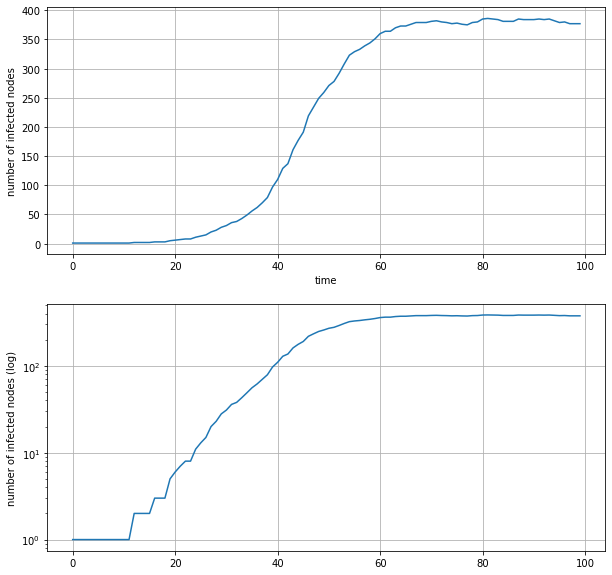

In [10]:
fig, [ax1, ax2] = plt.subplots(figsize=(10, 10), nrows=2)

_ = ax1.plot(totals)
ax1.grid(True)
ax1.set_ylabel('number of infected nodes')
ax1.set_xlabel('time')

ax2.set_yscale('log')
ax2.set_ylabel('number of infected nodes (log)')
ax2.grid(True)
ax1.set_xlabel('time')
_ = ax2.plot(totals)

## Epidemic spreading in random networks

Let us look into a more interesting network, an Erdös-Renyi random graph (https://en.wikipedia.org/wiki/Erdős–Rényi_model).
For this, we make use of the networkx library and a little helperfunction to generate an appropriate topology.

In [11]:
import networkx as nx

In [12]:
# number of nodes, edge probability
N, p = 150, 0.04
G = nx.erdos_renyi_graph(N, p)

In [13]:
# safe the positions of nodes to assure consistency in plots
layout = nx.spring_layout(G)

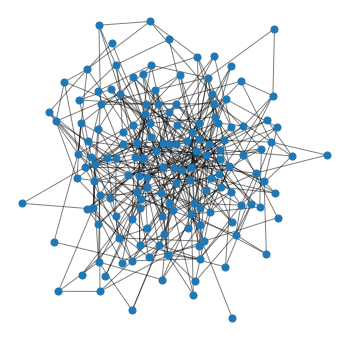

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axis('off')
_ = nx.draw_networkx_nodes(G, pos=layout, ax=ax, node_size=50, node_color='tab:blue')
_ = nx.draw_networkx_edges(G, pos=layout, alpha=0.5)

A similar helperfunction will be an upcoming feature in the next pygmo release...

In [15]:
class topology_from_matrix:
    """ Creates a fixed topology (no push_back)"""
    def __init__(self, M):
        """ M needs to be a numpy array, which encodes the migration weights. """
        assert M.shape[0] == M.shape[1]
        self.N = M.shape[0]
        self.M = M
        
    def get_connections(self, n):
        if n < self.N:
            pred = np.argwhere(self.M.T[n]).flatten().tolist()
            weights = [float(self.M[p, n]) for p in pred]
            return [ pred, weights ]
        else:
            return [ [], [] ]
            # anything outside the fixed topology is unconnected
            
            
    def push_back(self):
        # incremental construction of this topology is not supported
        pass
    
    def get_name(self):
        return f'fixed matrix topology (N = {self.N})'
    
    def get_matrix(self):
        return self.M

In [16]:
M = nx.adj_matrix(G).toarray().astype(np.uint8)
topo = topology_from_matrix(M)

Now we are ready to simulate **SIS** again! This time, we take some snapshots to visualize the spread in the network.

In [17]:
# play with the parameters of the simulation here
beta, delta = 0.5, 0.5
n_susceptible, n_infected = N - 1, 1 
eps = 0.1
steps = 100

# boilerplate
udp = sis_node(beta=beta, delta=delta)
prob = pg.problem(udp)
uda = sis_simul(eps=eps)
alg = pg.algorithm(uda)

# setting up initial state (randomly)
initial_infected = np.zeros(n_susceptible + n_infected)
initial_infected[:n_infected] = 1
np.random.shuffle(initial_infected)

archi = pg.archipelago()
archi.set_migration_type(pg.migration_type.broadcast)
# here we set the random network as topology
archi.set_topology(topo)

# initialize distributed simulation
for state in initial_infected:
    isl = pg.island(pop=init_pop(prob, state), algo=alg, s_pol=sis_select(), r_pol=sis_replace())
    archi.push_back(isl)

t1 = time()    

totals = []
snapshots = []

for i in range(0, steps):
    if i > 0 and total == 0.0:
        print('Extinction!')
        break
    archi.evolve(1)
    archi.wait_check()
    
    state = [x[0] for x in archi.get_champions_f()]
    total = sum(state)
    totals.append(total)
    buffersize = sum([len(isl.get_population()) - 1 for isl in archi])
    print(f'step {i}: total: {total} / buffer: {buffersize}')
    
    if not i % 10:
        snapshots.append((i, state))
    

print(f'time passed: {time() - t1:0.5f}')
snapshots.append((i, state))

step 0: total: 1.0 / buffer: 1
step 1: total: 1.0 / buffer: 6
step 2: total: 1.0 / buffer: 6
step 3: total: 1.0 / buffer: 6
step 4: total: 1.0 / buffer: 6
step 5: total: 1.0 / buffer: 6
step 6: total: 1.0 / buffer: 6
step 7: total: 1.0 / buffer: 6
step 8: total: 1.0 / buffer: 6
step 9: total: 1.0 / buffer: 6
step 10: total: 1.0 / buffer: 6
step 11: total: 1.0 / buffer: 6
step 12: total: 4.0 / buffer: 6
step 13: total: 4.0 / buffer: 11
step 14: total: 6.0 / buffer: 11
step 15: total: 7.0 / buffer: 15
step 16: total: 8.0 / buffer: 15
step 17: total: 8.0 / buffer: 15
step 18: total: 8.0 / buffer: 13
step 19: total: 8.0 / buffer: 18
step 20: total: 9.0 / buffer: 17
step 21: total: 10.0 / buffer: 23
step 22: total: 10.0 / buffer: 29
step 23: total: 11.0 / buffer: 28
step 24: total: 12.0 / buffer: 34
step 25: total: 14.0 / buffer: 36
step 26: total: 17.0 / buffer: 47
step 27: total: 20.0 / buffer: 52
step 28: total: 23.0 / buffer: 61
step 29: total: 23.0 / buffer: 69
step 30: total: 26.0 / b

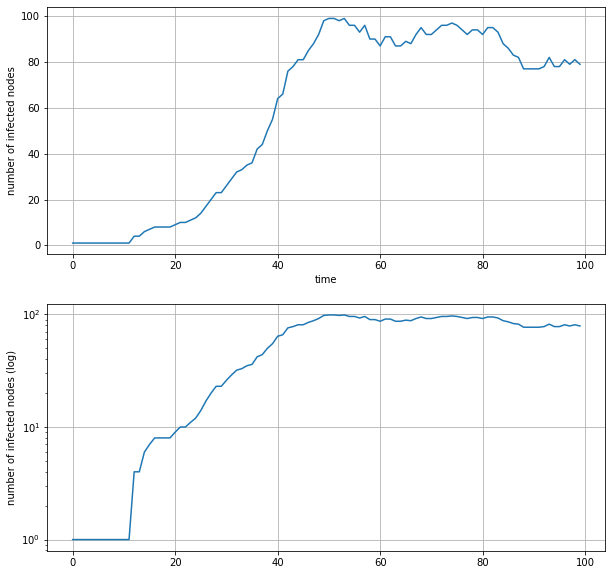

In [18]:
fig, [ax1, ax2] = plt.subplots(figsize=(10, 10), nrows=2)

_ = ax1.plot(totals)
ax1.grid(True)
ax1.set_ylabel('number of infected nodes')
ax1.set_xlabel('time')

ax2.set_yscale('log')
ax2.set_ylabel('number of infected nodes (log)')
ax2.grid(True)
ax1.set_xlabel('time')
_ = ax2.plot(totals)

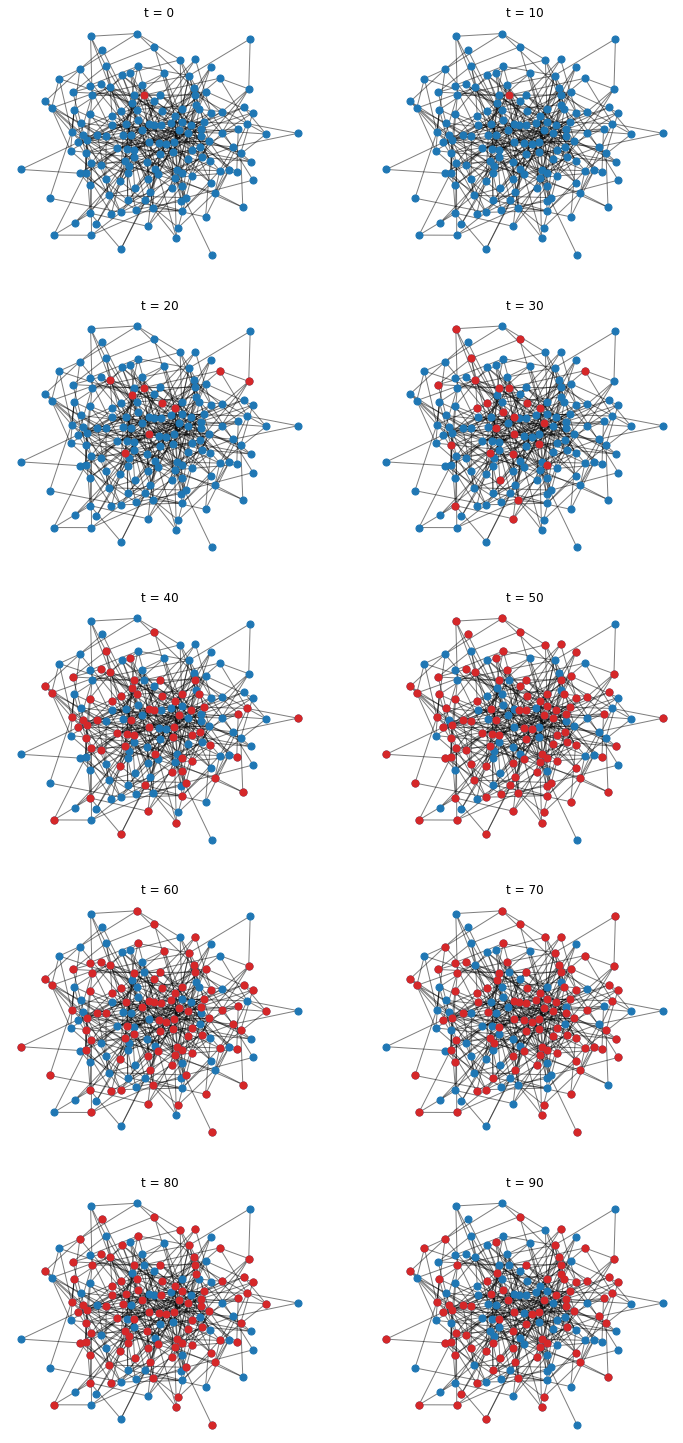

In [19]:
fig, axes = plt.subplots(figsize=(12, 26), nrows=5, ncols=2)

for (i, snapshot), ax in zip(snapshots, axes.flatten()):
    infected = np.nonzero(snapshot)[0].tolist()
    
    ax.axis('off')
    ax.set_title(f't = {i}')
    nx.draw_networkx_nodes(G, pos=layout, ax=ax, node_size=50, node_color='tab:blue')
    nx.draw_networkx_nodes(G, pos=layout, nodelist=infected, ax=ax, node_size=50, node_color='tab:red')
    nx.draw_networkx_edges(G, pos=layout, ax=ax, alpha=0.5)

and last, but not least...

## Can we simulate the spread of the Corona virus with this?

The short answer is: **NO!**

The **SIS**-model is a textbook mathematical model that is strong enough to capture certain affects and behaviours of real epidemics while still being amenable for analysis. If one would like to (reliably) simulate the spread of a virus like Corona, a lot of assumptions of SIS need to be dropped. Real world epidemics are characterised by

* variability in infection strength (depending on external factors like temperature)
* variability in curing process (depending on deployed countermeasures)
* heterogeneous networks: nodes respond differently to the virus and immunization may occur
* dynamic networks: contact networks of people show extremely fast dynamics which are interlinked with countermeasures
* non-Markovian spreading dynamics: the spreading and curing are not Poisson processes
* many compartments: Only two states "S" and "I" are insufficient to describe an infection with long incubation periods

Setting up a simulation that takes these factors into account is not easy and since the emergent behaviour of epidemics is poorly understood, many challenges remain.